In [1]:
import numpy as np
import pandas as pd
import xskillscore as xs
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import norm

In [2]:
def plot_gp(x, mu, std, color, label):
    """
    Plot predicted mean and filled area showing the 95% confidence interval around the predicted mean.

    Parameters
    ----------
    x : Numpy vector
        Values to use on x-axis.
    mu : EagerTensor
        Predicted mean of function, can be obtained as first output from the predict_f method on a GPFlow model.
    var : EagerTensor
        Predicted variance of function, can be obtained as second output from the predict_f method on a GPFlow model.
    color : str
        Color to use for filled area between mean and +/- two standard deviations. For example: '#ff7f0e'.
    label : str
        Label to put in legend.

    Returns
    -------
    None
        Plots the specified predicted mean and associated +/- two standard deviations.
    """
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(x,
                     (mu - 2*std),
                     (mu + 2*std),
                     color=color, alpha=0.4, label='Predicted $\mu \pm 2\sigma$')

In [3]:
n_obs = 10
linear_trend = np.arange(n_obs)
pred_means = xr.DataArray(np.zeros(shape=n_obs) + linear_trend)
pred_stds = xr.DataArray(np.ones(shape=n_obs))

obs = xr.DataArray(np.random.normal(loc=0.0  + linear_trend, scale=1.0, size=n_obs))

In [4]:
pred_means

<xarray.DataArray (dim_0: 10)>
array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
Dimensions without coordinates: dim_0

# Continuous ranked probability score

## Test influence of predicted variance on continuous ranked probability score

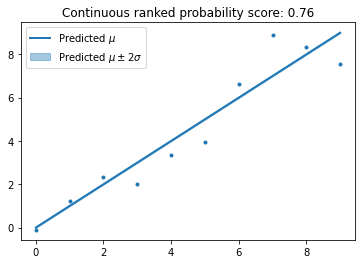

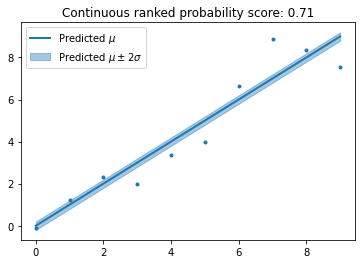

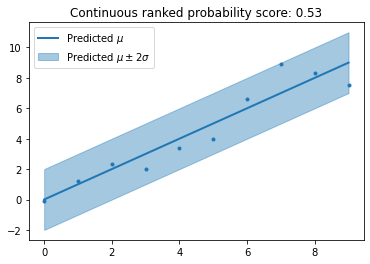

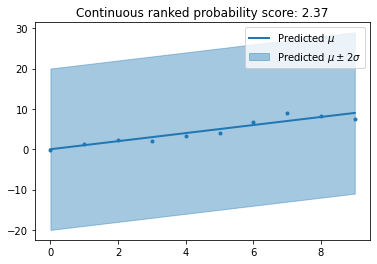

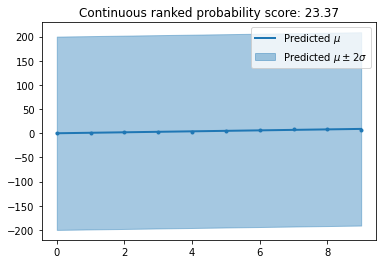

In [5]:
for factor in [0.01, 0.1, 1, 10, 100]:
    plt.figure()
    current_obs = obs
    current_pred_stds = pred_stds * factor
    crps = xs.core.probabilistic.crps_gaussian(current_obs, pred_means, current_pred_stds)
    line, = plt.plot(current_obs, '.')
    plot_gp(line.get_xdata(), pred_means, current_pred_stds, line.get_color(), label='Predicted $\mu$')
    plt.title('Continuous ranked probability score: ' + "{:.2f}".format(crps.data))
    plt.legend()

## Test influence of predicted mean on continuous ranked probability score

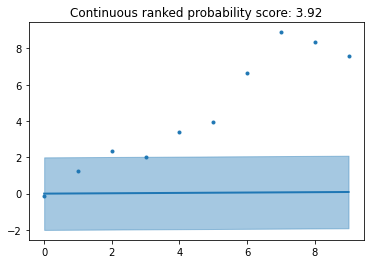

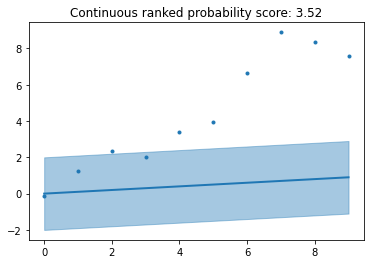

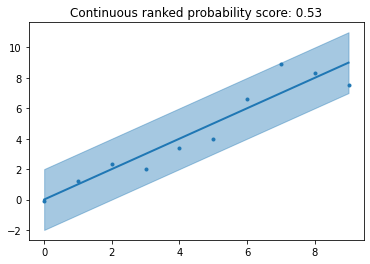

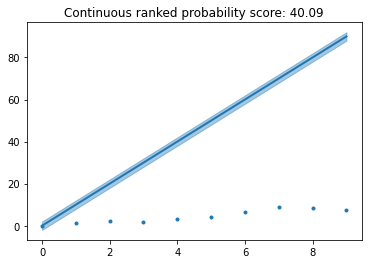

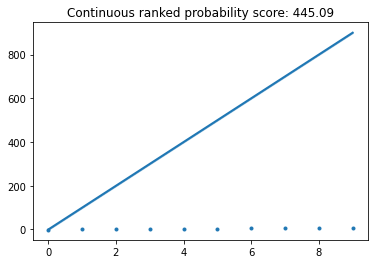

In [6]:
for factor in [0.01, 0.1, 1, 10, 100]:
    plt.figure()
    current_obs = obs
    current_pred_means = pred_means * factor
    crps = xs.core.probabilistic.crps_gaussian(current_obs, current_pred_means, pred_stds)
    line, = plt.plot(current_obs, '.')
    plot_gp(line.get_xdata(), current_pred_means, pred_stds, line.get_color(), label='Predicted')
    plt.title('Continuous ranked probability score: ' + "{:.2f}".format(crps.data))

# Brier score

In [7]:
threshold = xr.DataArray(
       pred_means,
       dims="threshold"
   )
threshold = current_obs.sortby(current_obs).data.tolist()

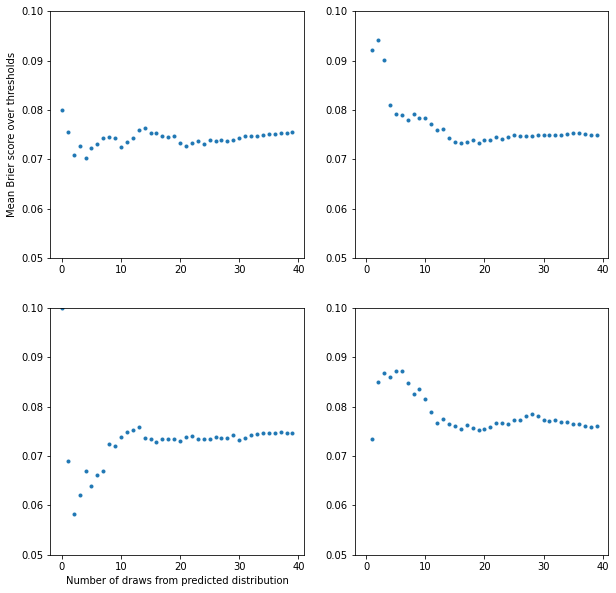

In [8]:
n_loops = 40
plt.figure(figsize=[10, 10])
for i_plot in range(1, 5):
    predicted_realizations = []
    brier_means = np.zeros(shape=n_loops)
    for i_loop in range(1, n_loops + 1):
        for i in range(i_loop):
            predicted_realizations.append(np.random.normal(loc=pred_means, scale=pred_stds))

        forecast = xr.DataArray(
               np.array(predicted_realizations),
               dims=["member", "dim_0"],
               name='var'
           )

        threshold_brier_score = xs.threshold_brier_score(current_obs, forecast, threshold=threshold, dim=None)
        # print(threshold_brier_score.data)
        # print(np.mean(threshold_brier_score.data))
        brier_means[i_loop - 1] = np.mean(threshold_brier_score.data)

    plt.subplot(2, 2, i_plot)
    plt.plot(np.arange(n_loops), brier_means, '.')
    plt.ylim(0.05, 0.1)
    if i_plot == 3:
        plt.xlabel('Number of draws from predicted distribution')
    if i_plot == 1:
        plt.ylabel('Mean Brier score over thresholds')

With about 15 realizations from the predicted distributions it seems we get a stable estimate of the Brier score

In [9]:
def get_forecast_ensemble(pred_means, pred_stds):
    predicted_realizations = []
    for i in range(15):
        predicted_realizations.append(np.random.normal(loc=pred_means, scale=pred_stds))

    forecast = xr.DataArray(
           np.array(predicted_realizations),
           dims=["member", "dim_0"],
           name='var'
       )
    return forecast

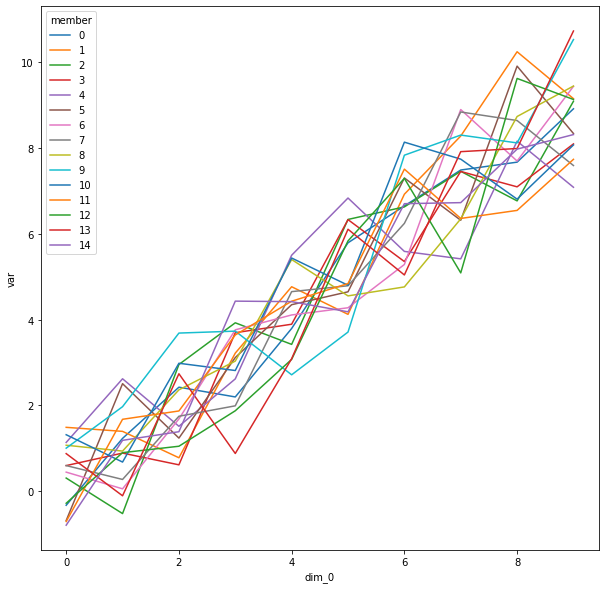

In [10]:
forecast = get_forecast_ensemble(pred_means, pred_stds)
plt.figure(figsize=[10, 10])
forecast.plot.line(x='dim_0')

## Test influence of predicted standard devistion on Brier score

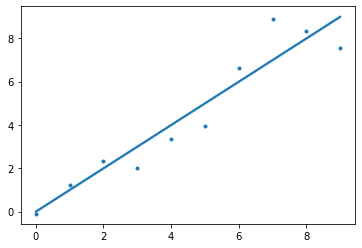

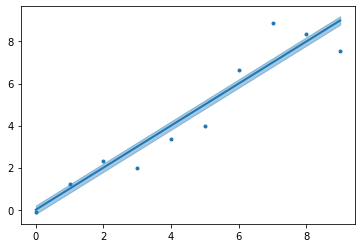

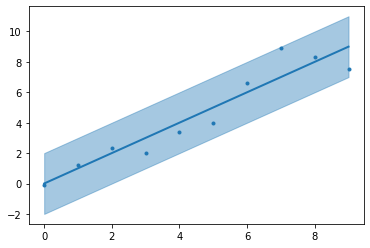

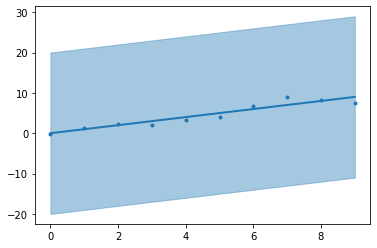

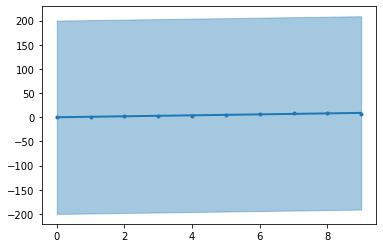

In [11]:
for factor in [0.01, 0.1, 1, 10, 100]:
    plt.figure()
    current_obs = obs
    current_pred_stds = pred_stds * factor
    forecast = get_forecast_ensemble(pred_means, current_pred_stds)
    brier_scores = xs.threshold_brier_score(current_obs, forecast, threshold=threshold, dim=None)
    brier_mean = np.mean(brier_scores.data)
    line, = plt.plot(current_obs, '.')
    plot_gp(line.get_xdata(), pred_means, current_pred_stds, line.get_color(), label='Predicted')
    # plt.title('Brier mean: ' + "{:.2f}".format(brier_mean))
    


## Test influence of predicted mean on Brier score

In [12]:
forecast.shape

(15, 10)

In [13]:
current_obs.shape

(10,)

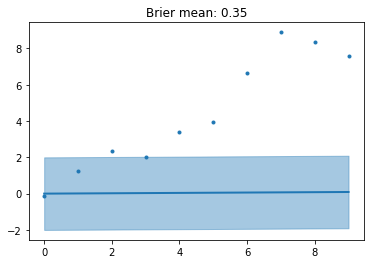

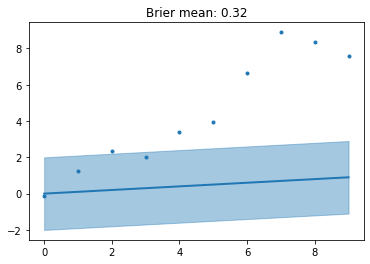

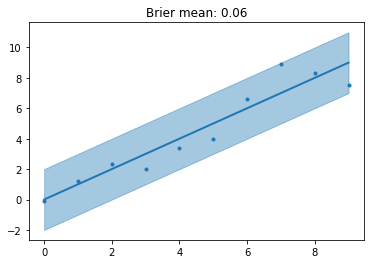

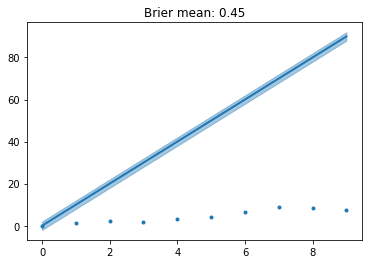

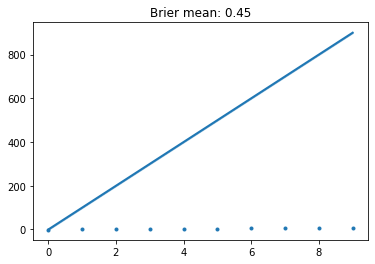

In [14]:
for factor in [0.01, 0.1, 1, 10, 100]:
    plt.figure()
    current_obs = obs
    current_pred_means = pred_means * factor
    forecast = get_forecast_ensemble(current_pred_means, pred_stds)
    brier_scores = xs.threshold_brier_score(current_obs, forecast, threshold=threshold, dim=None)
    brier_mean = np.mean(brier_scores.data)
    line, = plt.plot(current_obs, '.')
    plot_gp(line.get_xdata(), current_pred_means, pred_stds, line.get_color(), label='Predicted')
    plt.title('Brier mean: ' + "{:.2f}".format(brier_mean))
    


# Rank Histogram

In [15]:
forecast = get_forecast_ensemble(pred_means, pred_stds)
rank_hist_score = xs.rank_histogram(current_obs, forecast)
rank_hist_score

<xarray.DataArray 'histogram_rank' (rank: 16)>
array([0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 1, 0, 1, 0], dtype=int64)
Coordinates:
  * rank     (rank) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 12.0 13.0 14.0 15.0 16.0

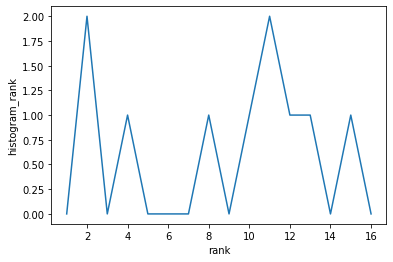

In [16]:
rank_hist_score.plot()

<BarContainer object of 16 artists>

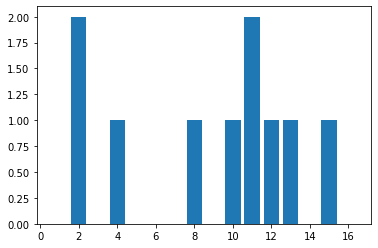

In [17]:
plt.bar(rank_hist_score.coords['rank'], rank_hist_score.data)

# ROC

In [18]:
bin_edges = np.arange(10)
roc_result = xs.roc(current_obs, forecast, bin_edges=bin_edges , return_results='all_as_metric_dim')  # , return_results='all_as_tuple'
roc_result

<xarray.DataArray 'histogram_observations_forecasts' (metric: 3, probability_bin: 10)>
array([[0.2       , 0.06666667, 0.06666667, 0.2       , 0.24444444,
        0.14444444, 0.07777778, 0.02857143, 0.10833333, 0.07333333],
       [0.97777778, 0.94074074, 0.90833333, 0.95555556, 0.98333333,
        0.95      , 0.75      , 0.75555556, 0.33333333, 0.        ],
       [0.90444885, 0.90444885, 0.90444885, 0.90444885, 0.90444885,
        0.90444885, 0.90444885, 0.90444885, 0.90444885, 0.90444885]])
Coordinates:
  * probability_bin  (probability_bin) int32 0 1 2 3 4 5 6 7 8 9
  * metric           (metric) <U19 'false positive rate' ... 'area under curve'

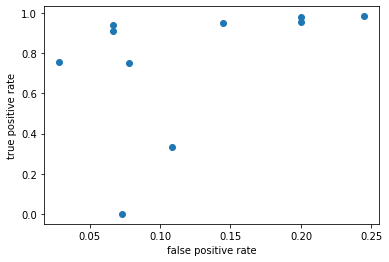

In [19]:
roc_result.to_dataset(dim='metric').plot.scatter(y='true positive rate', x='false positive rate')

In [20]:
roc_result.sel(metric='area under curve').values

array([0.90444885, 0.90444885, 0.90444885, 0.90444885, 0.90444885,
       0.90444885, 0.90444885, 0.90444885, 0.90444885, 0.90444885])

In [21]:
roc_result.sel(metric='false positive rate').values

array([0.2       , 0.06666667, 0.06666667, 0.2       , 0.24444444,
       0.14444444, 0.07777778, 0.02857143, 0.10833333, 0.07333333])

In [22]:
roc_result.sel(metric='true positive rate').values

array([0.97777778, 0.94074074, 0.90833333, 0.95555556, 0.98333333,
       0.95      , 0.75      , 0.75555556, 0.33333333, 0.        ])

In [23]:
roc_result

<xarray.DataArray 'histogram_observations_forecasts' (metric: 3, probability_bin: 10)>
array([[0.2       , 0.06666667, 0.06666667, 0.2       , 0.24444444,
        0.14444444, 0.07777778, 0.02857143, 0.10833333, 0.07333333],
       [0.97777778, 0.94074074, 0.90833333, 0.95555556, 0.98333333,
        0.95      , 0.75      , 0.75555556, 0.33333333, 0.        ],
       [0.90444885, 0.90444885, 0.90444885, 0.90444885, 0.90444885,
        0.90444885, 0.90444885, 0.90444885, 0.90444885, 0.90444885]])
Coordinates:
  * probability_bin  (probability_bin) int32 0 1 2 3 4 5 6 7 8 9
  * metric           (metric) <U19 'false positive rate' ... 'area under curve'